# Prédiction de la qualtité de l'air dans les villes de France métropolitaine à partir de données démographiques et économiques

Aymeric Lelièvre et Théo Sannier

## Introduction

La qualité de l'air est de nos jours une préoccupation croissante. Quoiqu'elle soit parfois masquée par la lutte contre le CO2 et le réchauffement climatique, la diminution des pollutions de l'air de tous types est un enjeu majeur. Elle est à l'origine de normes automobiles, de la piétonisation de certains centre-villes, ou encore de la baisse de la vitesse maximale sur le périphérique parisien à 50 km/h. L'OMS a en outre revu à la baisse ses seuils de pollution recommandés en 2021.

Dans cette étude, nous allons ainsi croiser des données sur la qualité de l'air avec plusieurs variables démographiques et économiques, pour essayer de déterminer des facteurs impactant la qualité de l'air.

## Installation

Commençons par importer les bibliothèques principales pour le traitement de données, la visualisation et la modélisation, ainsi que les scripts contenants les fonctions les plus volumineuses.

In [1]:
!pip install cartiflette

In [2]:
# Configuration et Imports

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm
import warnings

from cartiflette import carti_download
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
import warnings
from scripts import preprocessing as prep
from scripts import descriptive_visualization as viz
from scripts import add_city_columns_insee, pol_visualization, lasso, cart


# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
viz.setup_styles()

print("Environnement chargé avec succès.")

Environnement chargé avec succès.


## Partie 1 : Préparation et analyse descriptive des données

Notre étude repose sur 3 jeux de données. Le premier est une base de données sur la qualité de l'air en France téléchargée sur le site Geod'air. Les 2 autres sont issus du site de l'INSEE et portent sur les caractéristiques démographiques et économiques (démo-éco dans la suite) des villes françaises.

Les données démo-éco ne sont toutefois pas disponibles pour chaque année sur le site de l'INSEE. Nous avons ainsi récupéré des données qui datent de 2021, 2022 ou 2023. Afin de correspondre au mieux à ces données, nous avons téléchargé sur Geod'air une moyenne annuelle de la pollution sur l'année 2022. L'hypothèse que les données démo-éco des villes françaises ne varient pas significativement d'une année sur l'autre nous semble raisonnable, et garantit la pertinence de notre étude.

In [3]:
# Chemin d'accès aux données

path_air = "data/raw_data/data_air_2022.csv"
path_villes = "data/raw_data/data.csv"
path_tourisme = "data/raw_data/BDD_tourisme_communes_2022.csv"

### a) Qualité de l'air

#### Chargement et préparation des données

Les données sur la qualité de l'air ont été téléchargées depuis le site Geod'air, qui concentre un certains nombre de stations de mesure de la pollution. Nous nous concentrons sur l'étude des 4 polluants comportant le plus de stations de mesure en France : NOX as NO2, O3, PM2.5, et PM10.

In [4]:
geodair = pd.read_csv(path_air, sep=";")
geodair.head()

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,Réglementaire,type d'évaluation,type de valeur,valeur,valeur brute,unité de mesure,taux de saisie,couverture temporelle,couverture de données,code qualité,validité,Latitude,Longitude
0,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833
1,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01018,Scy-Chazelles,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,54.0,53.926047,µg-m3,NaN,NaN,NaN,R,1,49.107502,6.122775
2,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01020,Thionville-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,53.0,53.333492,µg-m3,NaN,NaN,NaN,R,1,49.358337,6.156942
3,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01021,Thionville-Garche,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,57.0,56.856089,µg-m3,NaN,NaN,NaN,R,1,49.394444,6.201392
4,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR02001,Berre l'Etang,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,66.0,66.176223,µg-m3,NaN,NaN,NaN,R,1,43.486234,5.171939


Afin de pouvoir, à l'avenir, fusionner cette base de données avec les données démographiques et économiques des villes, il nous faut le code INSEE de la ville de chacune des stations de mesure recensée sur le site Geod'air. 

Ce code INSEE peut être obtenu à partir des coordonnées d'une station de mesure grâce à l'api de data.gouv.fr disponible à l'adresse suivante : https://api-adresse.data.gouv.fr/reverse

La cellule suivante ajoute un colonne "Ville" et une colonne "CODGEO" au dataset geodair contenant respectivement le nom et le code INSEE de la ville où se situe chaque station. (L'execution de cette cellule prend 2 minutes à cause du recours à l'API et de la limite du nombre de requêtes par seconde. Il est également possible de charger directement le dataset déjà constitué 9 cellules plus bas.)

In [5]:
add_city_columns_insee.add_city_codes(geodair)

Cependant l'API de l'INSEE n'a pas réussi à trouver le code INSEE correspondant à certaines stations.

In [6]:
n_not_found = geodair[geodair["CODGEO"].isna()].shape[0]
print(str(n_not_found) + " codes INSEE non trouvés.")

25 codes INSEE non trouvés.


Il doit s'agir de stations trop éloignées d'une ville, qui sont donc peu pertinentes pour notre étude. Leur nombre n'étant pas trop important, nous décidons de simplement les supprimer.

In [7]:
n_before = geodair.shape[0]
geodair = geodair.dropna(subset = ['CODGEO'])
n_after = geodair.shape[0]

print(str(n_before - n_after) + " lignes supprimées.")

25 lignes supprimées.


Afin de pouvoir, lors des visualisations futures, afficher des points correspondant aux villes et non aux stations (une ville pouvant contenir plusieurs stations de mesure), il nous faut également les coordonnées des villes. 

On obtient celles-ci en fusionnant le dataset geodair avec des données de l'INSEE sur les villes (et notamment leurs coordonnées).

In [8]:
communes = pd.read_csv("data/raw_data/20230823-communes-departement-region.csv")

communes = communes[["code_commune_INSEE", "latitude", "longitude"]].rename(columns={
    "code_commune_INSEE": "CODGEO",
    "latitude": "Latitude_commune",
    "longitude": "Longitude_commune"
})

communes = communes.drop_duplicates(subset=["CODGEO"])

geodair = geodair.merge(
    communes,
    on="CODGEO",
    how="left"
)


On se concentre sur la France métropolitaine. On supprime donc les stations d'Outre-mer et de Corse.

In [9]:
geodair = geodair[~geodair["CODGEO"].str.startswith(("2A", "2B", "97"))]

Il est possible de charger directement le dataset final, sans avoir eu à attendre l'exécution de l'API, en exécutant la cellule suivante.

In [10]:
# geodair = pd.read_csv("data/processed_data/geodair_2022_villes_codgeo_final.csv", sep=",")

#### Répartition géographique des villes de France considérées

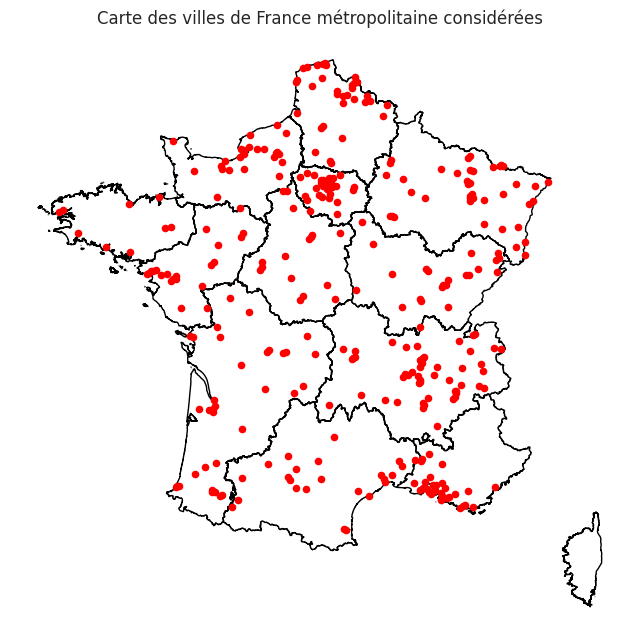

In [31]:
import geopandas as gpd
from cartiflette import carti_download
import matplotlib.pyplot as plt

france = carti_download(
      values = ["France"],
      crs = 4326,
      borders = "REGION",
      vectorfile_format="geojson",
      simplification=50,
      filter_by="FRANCE_ENTIERE",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)
france = france.loc[france['INSEE_REG']>10]

geodair_villes = geodair[['Ville', 'Latitude_commune', 'Longitude_commune']].drop_duplicates()

geodair_gdf = gpd.GeoDataFrame(
    geodair_villes,
    geometry=gpd.points_from_xy(geodair_villes["Longitude_commune"], geodair_villes["Latitude_commune"]),
    crs="EPSG:4326"
)

ax = france.plot(figsize=(8,8), edgecolor="black", facecolor="none")
geodair_gdf.plot(ax=ax, color="red", markersize=20)
ax.set_axis_off()

plt.title("Carte des villes de France métropolitaine considérées")
plt.show()

Les données de Geod'air nous permettent donc d'avoir accès à un large panel géographique de villes.

#### Analyse descriptive de la qualité de l'air

Nous pouvons ensuite visualiser les niveaux de pollution par polluant (NOX as NO2, O3, PM2.5 et PM10) dans les différentes villes. 

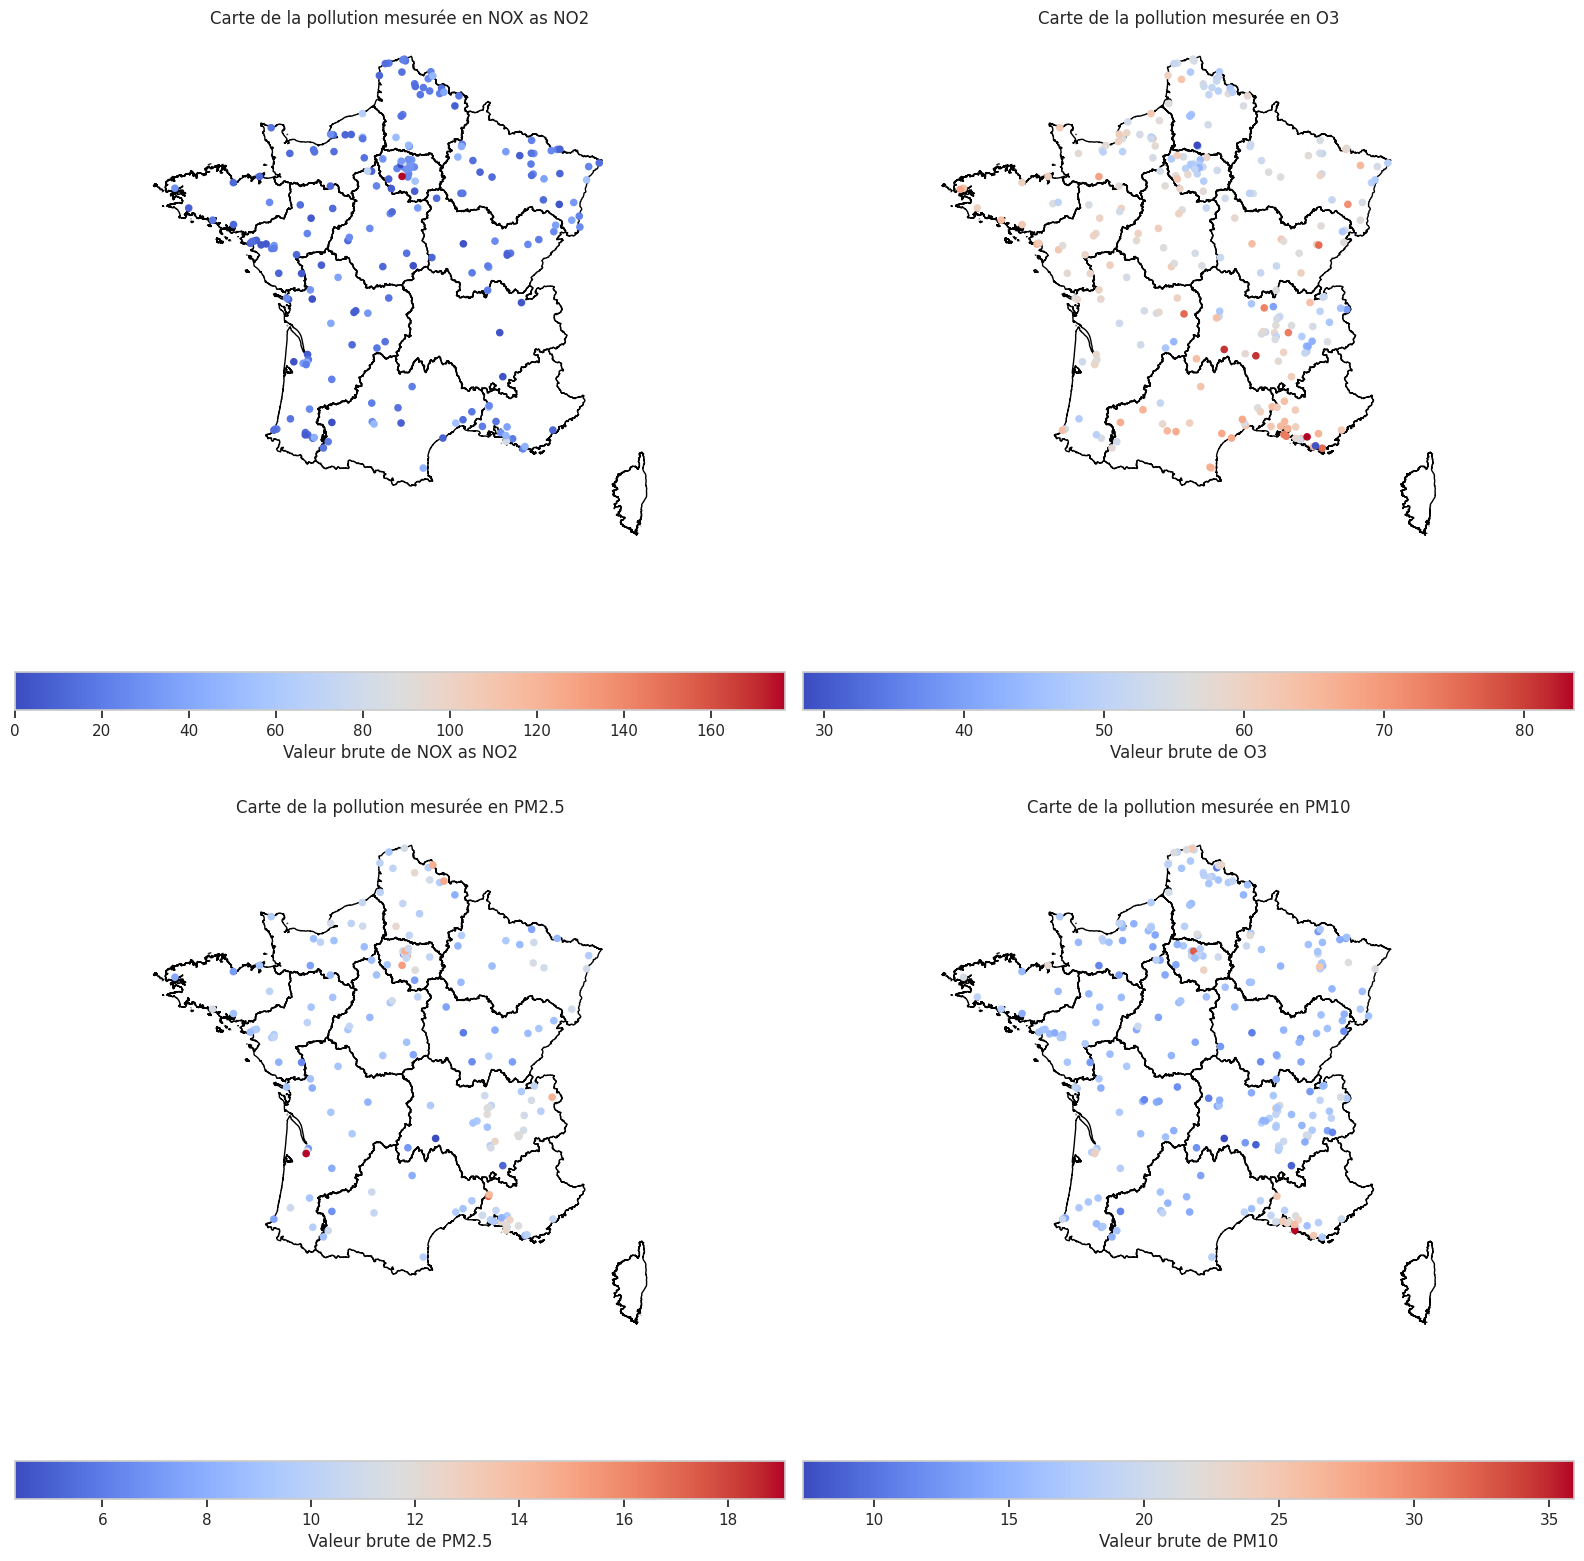

In [12]:
pol_visualization.visualization(geodair)

La qualité de l'air varie donc fortement selon les villes, et ceci différemment en fonction du polluant considéré.

Afin de mettre ces données en perspective, on peut également représenter le respect ou non des seuils de pollution recommandés par l'OMS en 2021 (nos données datant de 2022).

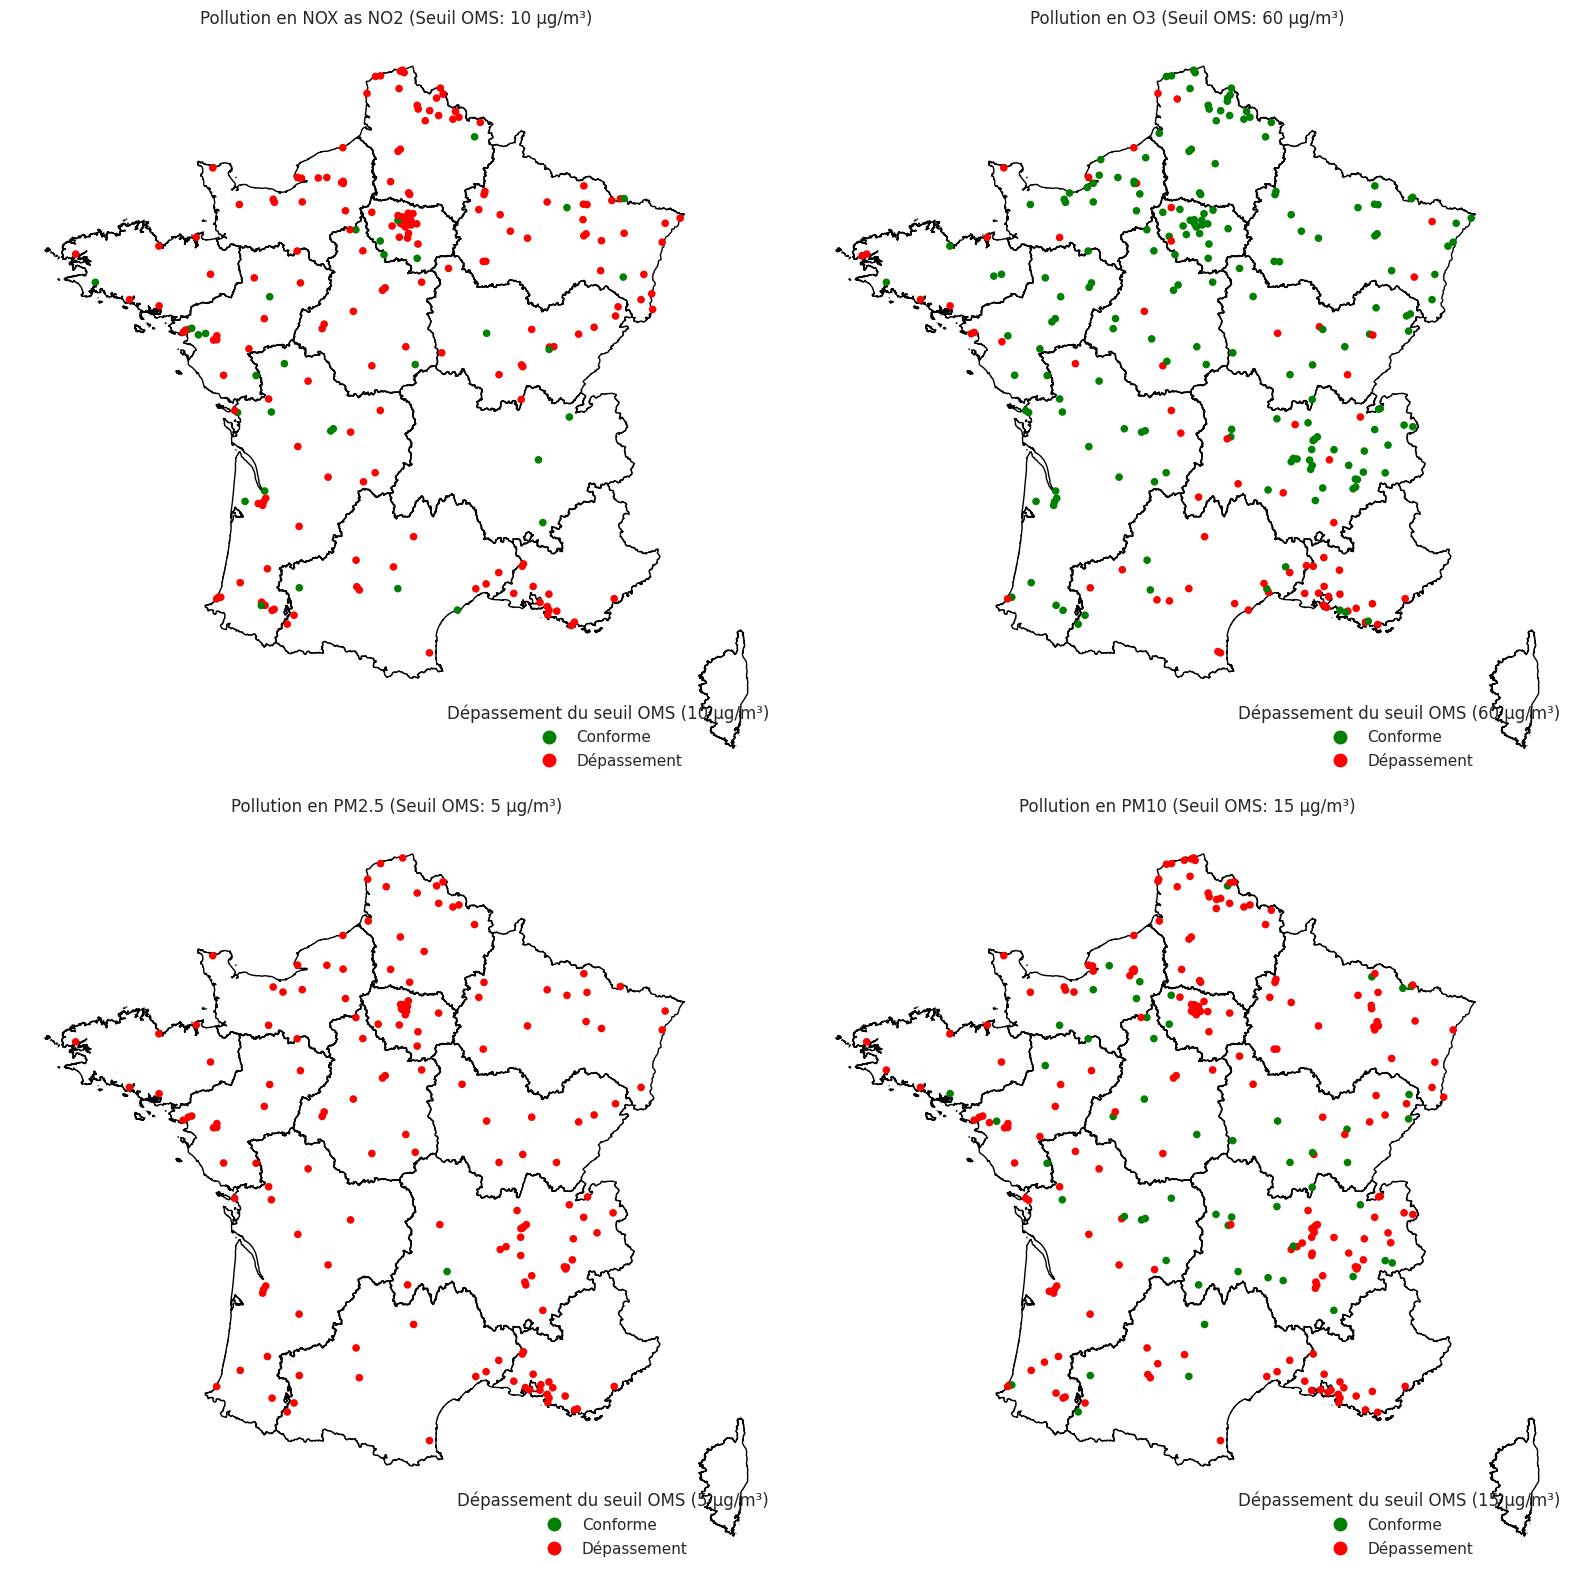

In [13]:
pol_visualization.visualization_OMS(geodair)

On peut constater que les seuils de pollution recommandés par l'OMS sont dépassés dans de nombreuses villes, et ce pour tous les polluants considérés.

Réduire la pollution est donc une priorité, et déterminer les facteurs démo-éco de la pollution est un premier pas pour résoudre ces problèmes.

### b) Caractéristiques démographiques et économiques des villes de France métropolitaine

#### Chargement et préparation des données

Nos données économiques et démographiques sont divisées en 2 datasets, qu'il convient alors de fusionner pour n'en manipuler qu'un seul, contenant toutes les informations sur les villes. Cette fusion des deux datasets requiert d'être vigilant aux noms et types des variables sur lesquelles s'opère la jointure. A ce titre, des conversions de des renommages sont effectués.

Aussi, le champs de notre étude ne porte que sur les villes en France métropolitaine. Ainsi, les villes de Corse et d'outre-mer sont supprimées de notre base de données.

In [14]:
# Chargement initial des datasets
df_raw_villes = prep.load_and_merge_cities(path_villes, path_tourisme)

print(f"Après fusion : {df_raw_villes.shape[0]} lignes, {df_raw_villes.shape[1]} colonnes")
print(f"Doublons détectés : {df_raw_villes.duplicated().sum()}")
print(f"Nom des colonnes : {list(df_raw_villes.columns)}")

# Nettoyage (Renommage, Typage, Filtrage DOM-TOM)
df_villes_clean = prep.process_city_data(df_raw_villes)

# Sauvegarde intermédiaire
df_villes_clean.to_csv("data/processed_data/data_villes_tourisme.csv", index=False)

print(f"Dataset Villes nettoyé : {df_villes_clean.shape}")
display(df_villes_clean.head())

Après fusion : 34875 lignes, 12 colonnes
Doublons détectés : 0
Nom des colonnes : ['CODGEO', 'Libellé', 'Part des effectifs des commerces, transports, services divers 2023', 'Population municipale 2022', "Nombre d'établissements 2023", 'Densité de population (historique depuis 1876) 2022', "Taux d'activité par tranche d'âge 2022", 'Médiane du niveau de vie 2021', "Part des effectifs de l'industrie 2023", 'Part des effectifs de la construction 2023', 'Nb_hotels_2022', 'Nb_campings_2022']
Dataset Villes nettoyé : (34386, 12)


,code_geo,libelle,part_commerce_transport_services_2023,population_2022,nb_etablissements_2023,densite_population_2022,taux_activite_2022,mediane_niveau_vie_2021,part_industrie_2023,part_construction_2023,nb_hotels_2022,nb_campings_2022
0,1001,L'Abergement-Clémenciat,19.2,859.0,16.0,53.9,82.1,25820.0,0.0,30.8,0.0,0.0
1,1002,L'Abergement-de-Varey,50.0,273.0,4.0,29.8,80.1,24480.0,0.0,0.0,0.0,0.0
2,1004,Ambérieu-en-Bugey,54.6,15554.0,599.0,632.3,76.7,21660.0,7.5,6.0,1.0,0.0
3,1005,Ambérieux-en-Dombes,27.9,1917.0,45.0,120.4,81.3,24610.0,19.8,15.2,2.0,1.0
4,1006,Ambléon,0.0,114.0,1.0,19.4,70.8,24210.0,0.0,0.0,0.0,0.0


#### Analyse descriptive des villes de France métropolitaine

Commençons par étudier ce dataset contenant des informations sur toutes les villes de France. Cette approche exploratoire nous permettra de construire des éléments de référence pour l'analyse des relevés de pollution. Il s'agit ici de construire des histogrammes pour approximer la distributions de nos variables, ainsi qu'un corrélogramme pour donner un aperçu des relations linéaires qui unissent les variables.

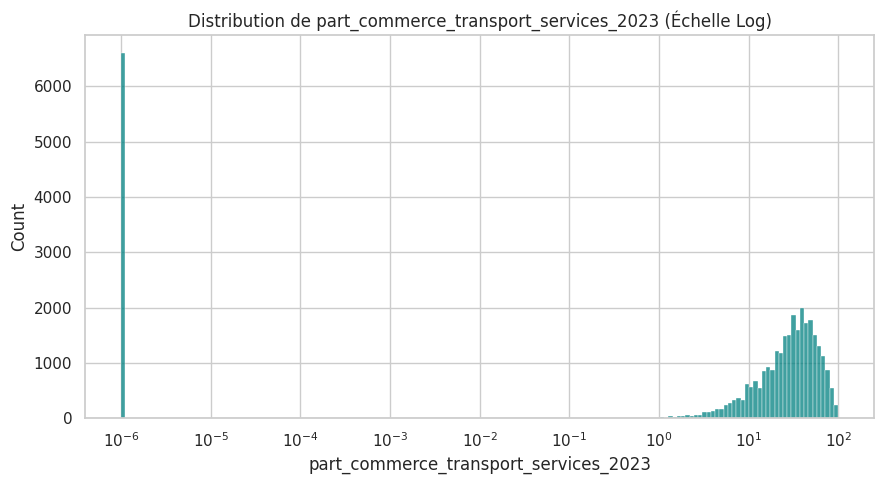

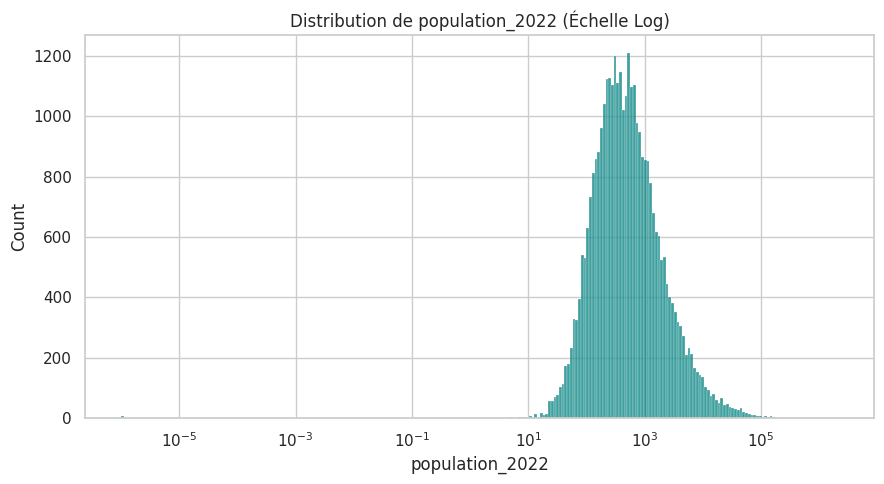

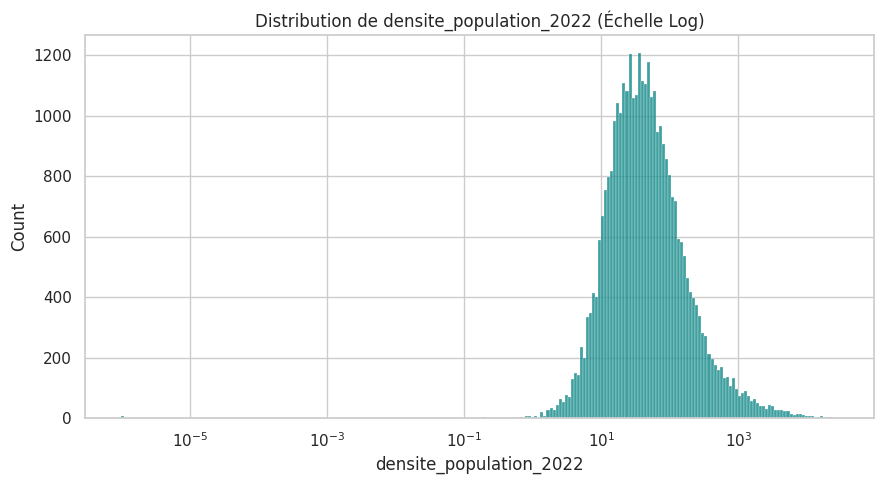

Graphiques de distribution générés dans 'output/Desc_All_Cities'


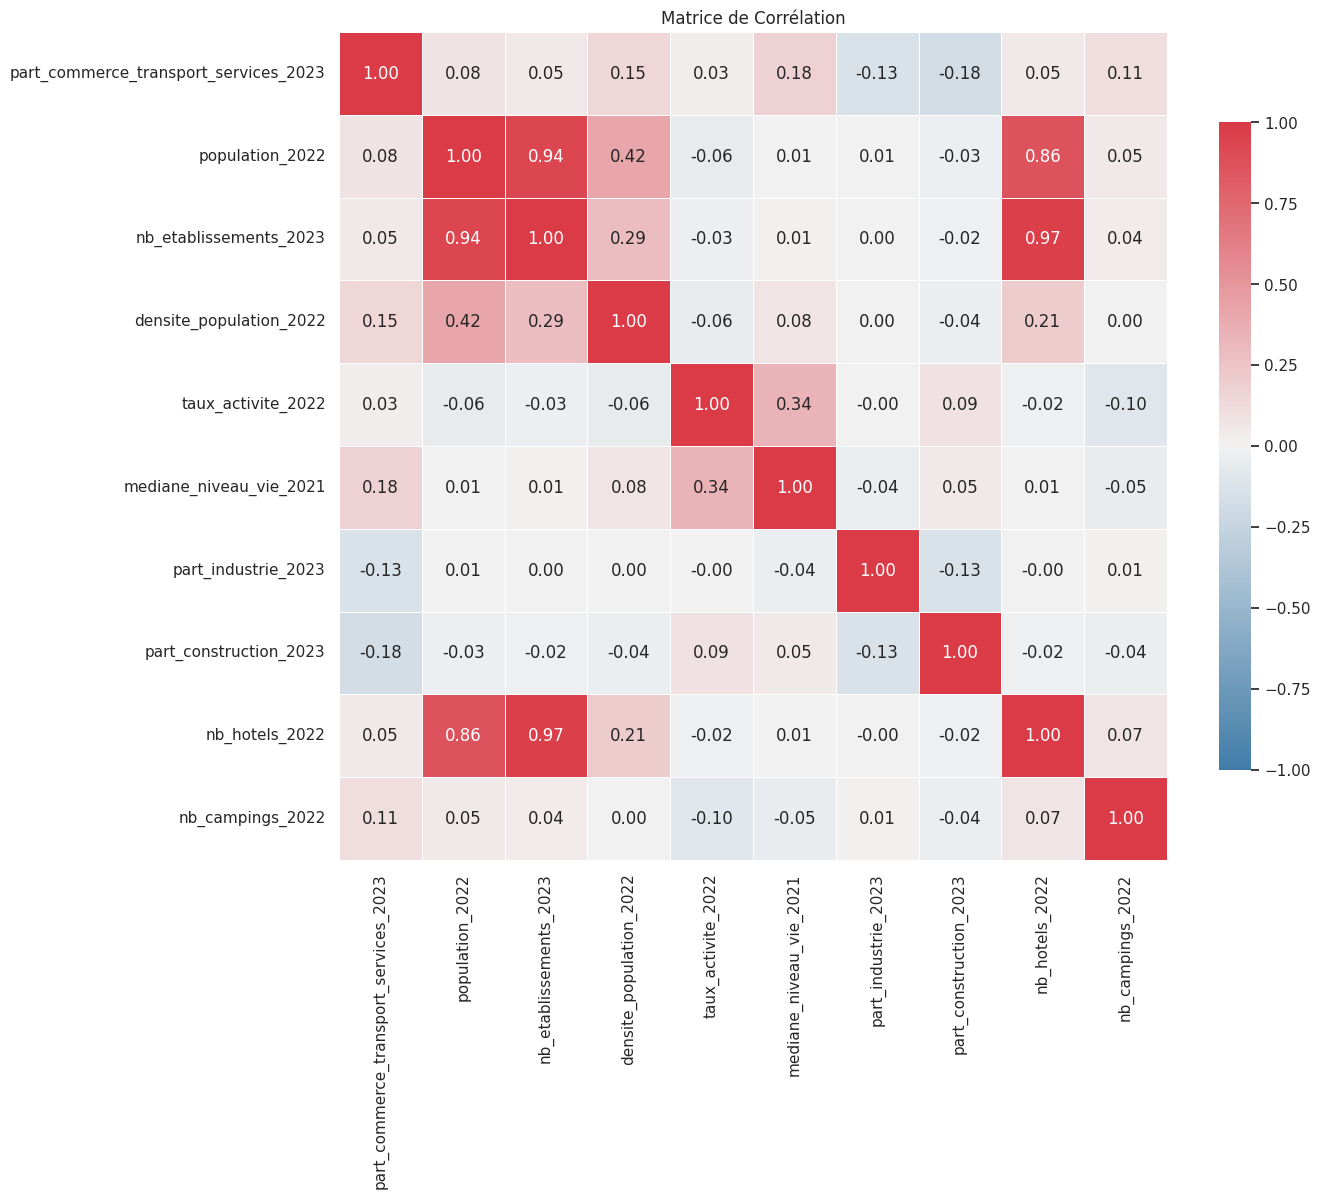

Matrice de corrélation générée.


In [15]:
# Visualisation des distributions
dists_to_save = ['nb_etablissements_2023', 'taux_activite_2022',
                 'mediane_niveau_vie_2021', 'part_industrie_2023',
                 'part_construction_2023', 'nb_hotels_2022', 'nb_campings_2022']
dists_to_save_and_plot = ['part_commerce_transport_services_2023', 'population_2022', 'densite_population_2022']
viz.plot_distributions(df_villes_clean, dists_to_save, display=False)
viz.plot_distributions(df_villes_clean, dists_to_save_and_plot, display=True)

print("Graphiques de distribution générés dans 'output/Desc_All_Cities'")


# Matrice de Corrélation
viz.plot_correlation_heatmap(df_villes_clean, display=True)
print("Matrice de corrélation générée.")

**Analyse des distributions:** On observe que les distributions des variables éco-démo. des villes sont, pour la plupart, de 2 types. En effet, certaines semblent se rapprocher d'une distribution gaussienne (ex: population_2022, densite_population_2022) tandis que d'autres semblent présenter une forte inflation en 0, combinée avec une gaussienne (ex: part_commerce_transport_services_2023). L'étude de toutes les distributions montre que les caractéristiques des villes de France sont très homogènes, avec néanmoins une grande majorité de petites villes rurales avec peu d'activité économique et commerciale (ce qui explique l'inflation en 0 de certaines distributions.)

**Analyse du corrélogramme:** Quelques variables semblent très corrélées (linéairement). En particulier, le nombre d'établissements dans la ville en 2023 est un excellent proxy (presque proportionnel) à la population de cette même ville et à son nombre d'hotels. Remarquons aussi que dans une moindre mesure, les villes les plus peuplées sont aussi les plus denses.

### c) Caractéristiques démographiques et économiques des villes considérées dans notre étude sur la qualité de l'air

#### Fusion des bases de données

Maintenant que nous en savons plus sur les villes de France, il est temps de comparer avec les villes ayant des stations de mesure. Pour cela, commençons par joindre les données des relevés de pollution avec les données éco-démo des villes dans lesquelles ces relevés sont effectués.

In [16]:
# Préparation et fusion (gestion des codgeo, types)
df_etude_complete = prep.prepare_geodair_data(geodair, df_villes_clean)
print("Extrait de la base de données d'étude complète:")
display(df_etude_complete.head(5))
# Sauvegarde du dataset complet
df_etude_complete.to_csv("data/processed_data/data_etude_villes_relevees.csv", index=False, sep=";")

print(f"Dataset Étude Complet : {df_etude_complete.shape}")

Extrait de la base de données d'étude complète:


,date_debut,date_fin,organisme,code_zas,nom_zas,code_site,nom_site,type_implantation,polluant,type_influence,reglementaire,type_evaluation,type_valeur,valeur,valeur_brute,unite,taux_saisie,couverture_temporelle,couverture_donnees,code_qualite,validite,latitude_site,longitude_site,ville,codgeo,latitude_commune,longitude_commune,nom_commune,part_commerce_transport_services_2023,population_2022,nb_etablissements_2023,densite_population_2022,taux_activite_2022,mediane_niveau_vie_2021,part_industrie_2023,part_construction_2023,nb_hotels_2022,nb_campings_2022
0,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,51.0,50.614131,µg-m3,NaN,NaN,NaN,R,1,49.119442,6.180833,Metz,57463,49.108113,6.195525,Metz,45.8,121695.0,5203.0,2901.6,70.9,20940.0,4.6,3.6,26.0,1.0
1,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01018,Scy-Chazelles,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,54.0,53.926047,µg-m3,NaN,NaN,NaN,R,1,49.107502,6.122775,Scy-Chazelles,57642,49.114042,6.119849,Scy-Chazelles,67.8,2665.0,80.0,589.6,75.3,28380.0,0.3,7.9,0.0,0.0
2,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01020,Thionville-Centre,Urbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,53.0,53.333492,µg-m3,NaN,NaN,NaN,R,1,49.358337,6.156942,Thionville,57672,49.375972,6.129283,Thionville,43.8,42778.0,1494.0,857.6,77.0,24850.0,6.4,2.9,8.0,1.0
3,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01021,Thionville-Garche,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,57.0,56.856089,µg-m3,NaN,NaN,NaN,R,1,49.394444,6.201392,Thionville,57672,49.375972,6.129283,Thionville,43.8,42778.0,1494.0,857.6,77.0,24850.0,6.4,2.9,8.0,1.0
4,2022/01/01 00:00:00,2022/12/31 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR02001,Berre l'Etang,Périurbaine,O3,Fond,Oui,mesures fixes,Moy. annuelle,66.0,66.176223,µg-m3,NaN,NaN,NaN,R,1,43.486234,5.171939,Berre-l'Étang,13014,43.503644,5.160614,Berre-l'Étang,45.2,13941.0,461.0,319.5,74.1,20370.0,19.1,14.7,1.0,0.0


Dataset Étude Complet : (1103, 38)


#### Analyse comparative des villes de notre étude avec les villes de France métropolitaine

Enfin, avant de mener nos analyses, remarquons que certaines villes possèdent plusieurs points de mesure. Pour n'avoir qu'un point par ville et par polluant, on agrège les valeurs des relevés au sein d'une même ville en prenant la moyenne de ceux-ci.

In [17]:
# Agrégation par Polluant et Ville
df_groupe = prep.aggregate_by_pollutant(df_etude_complete)

polluants = df_groupe["polluant"].unique()
print(f"Polluants identifiés : {polluants}")

Polluants identifiés : ['NOX as NO2' 'O3' 'PM10' 'PM2.5']


Pour chacun de nos 4 polluants, nous étudions l'échantillon de villes associé. Pour préparer les analyses suivantes, nous divisons notre dataset en 4 (un dataset par polluant).

Pour les analyses, nous comparons:

- Le proportion de petites/moyennes/grandes villes de nos échantillons
- Les moyennes des variables éco-démo.
- Les distributions des variables éco-démo.

Polluants identifiés : ['NOX as NO2' 'O3' 'PM10' 'PM2.5']
--- Traitement : NOX as NO2 ---

>> Distribution par taille de ville pour : NOX as NO2


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),24,11.27,8.000
Petite (2-10k),29,13.62,20.862
Moyenne (10-50k),84,39.44,22.512
Grande (>50k),66,30.99,32.078


--- Traitement : O3 ---

>> Distribution par taille de ville pour : O3


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),40,15.21,62.075
Petite (2-10k),46,17.49,56.457
Moyenne (10-50k),101,38.40,54.931
Grande (>50k),60,22.81,55.694


--- Traitement : PM10 ---

>> Distribution par taille de ville pour : PM10


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),22,8.53,13.864
Petite (2-10k),45,17.44,16.822
Moyenne (10-50k),106,41.09,17.085
Grande (>50k),70,27.13,18.508


--- Traitement : PM2.5 ---

>> Distribution par taille de ville pour : PM2.5


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),16,9.64,7.875
Petite (2-10k),15,9.04,10.100
Moyenne (10-50k),65,39.16,9.969
Grande (>50k),58,34.94,10.282


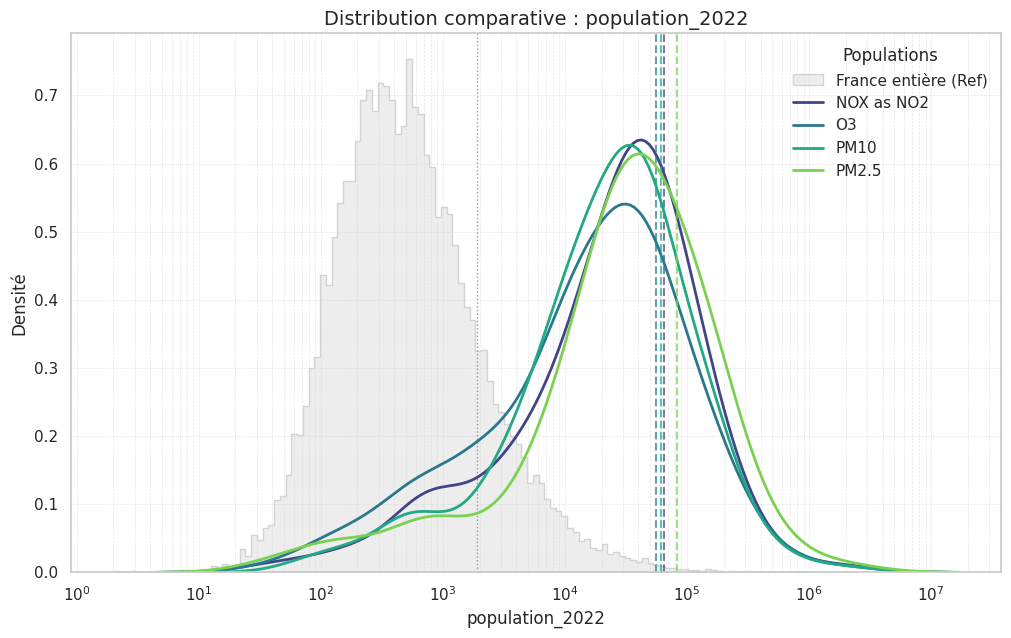

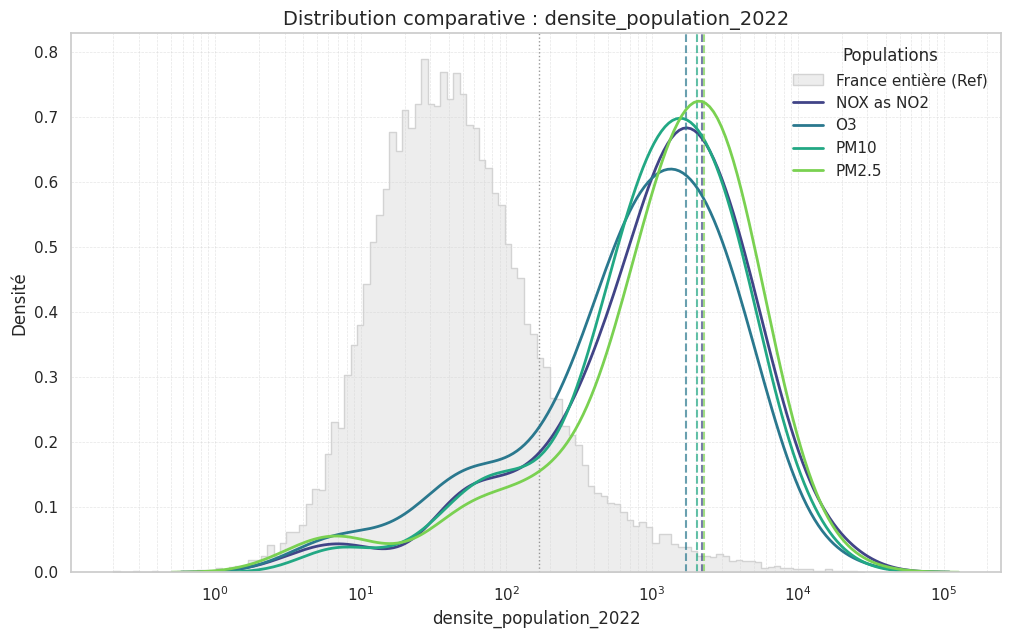

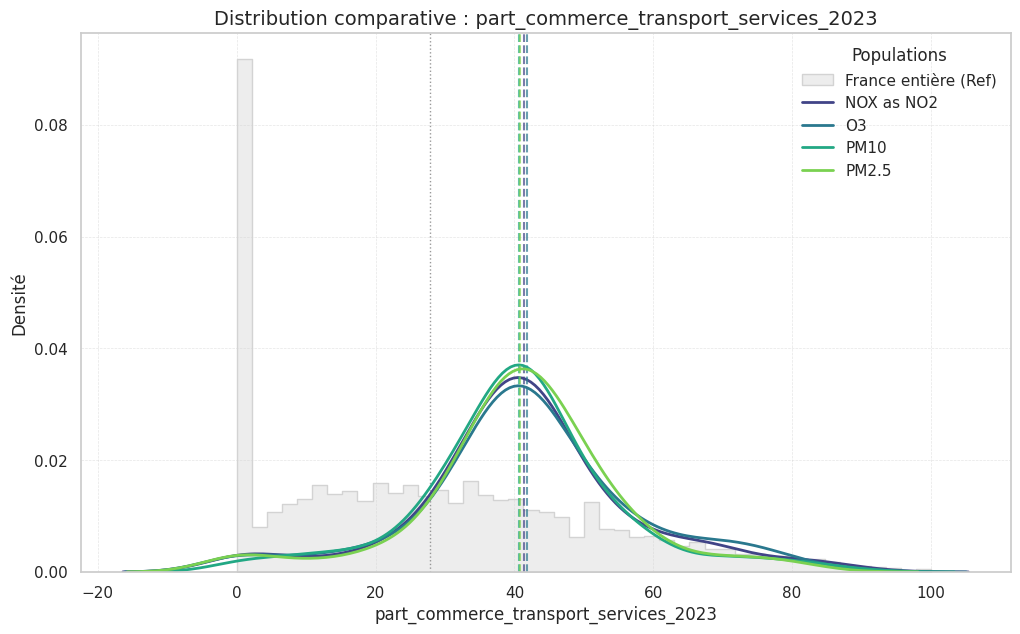

Graphiques générés dans : output/plots_comparaison

Analyse terminée. Tous les graphiques sont générés.


In [18]:
polluants = df_groupe["polluant"].unique()
print(f"Polluants identifiés : {polluants}")
# Génération des Datasets par Polluant et Plots Comparatifs
vars_eco = {
    "population_2022": True,
    "mediane_niveau_vie_2021": False,
    "densite_population_2022": True,
    "part_commerce_transport_services_2023": True,
    "part_industrie_2023": False,
    "nb_hotels_2022": False,
    "nb_etablissements_2023": False,
    "taux_activite_2022": False,
    "part_construction_2023": False,
    "nb_campings_2022": False
}

df_combined = {}
for pol in polluants:
    print(f"--- Traitement : {pol} ---")
    
    # Filtre et Sauvegarde
    df_pol = df_groupe[df_groupe["polluant"] == pol]
    df_pol.to_csv(f"data/processed_data/BDD_par_polluant/dataset_{pol}_final.csv", index=False, sep=';')
    df_combined[pol] =df_pol
    # Comparaison des proportions de petites, moyennes et grandes villes
    stats = prep.analyze_city_size_distribution(df_pol, pol)
    display(stats)
    
    # Plots Comparatifs (France vs Echantillon)
    viz.plot_comparative_distributions(
        df_sample=df_pol, 
        df_france=df_villes_clean, 
        polluant_name=pol, 
        vars_eco=vars_eco,
    )

    # Etude des corrélations entre la concentration de polluant et les variables éco-démo.
    viz.plot_correlation_heatmap(df_pol, pol=pol)

viz.plot_combined_distributions_per_var(df_combined, df_villes_clean, vars_eco,)
print("\nAnalyse terminée. Tous les graphiques sont générés.")

**Analyse des tableaux récapitulatifs:** On remarque que les échantillons de chaque polluant comportent globalement les mêmes proportions de chaque taille de ville. En particulier, les moyennes et grandes villes sont majoritaires dans nos échantillons, et donc sur-représentées par rapport à la distribution de toutes les villes de France. Nos échantillons ne sont donc pas représentatifs des villes françaises, mais dans le cadre de notre étude sur les déterminants de la pollution, la présence de chaque type de ville dans notre échantillon en bonne quantité semble plutôt un atout.

De plus, remarquons que seuls les "NOX as NO2" semblent être dépendant de la taille de la ville. Ce constat est attendu car ce polluant est principalement émis par le transport routier et le secteur industriel. A l'inverse, l'O3, les PM2.5 et les PM10 sont des polluants eux aussi d'origine humaine, mais que l'on pourrait qualifier d'indirects, ie. formés à l'issue de réactions chimiques post-émissions. A ce titre, la corrélation entre concentration de ces polluants et taille de la ville.

**Analyse des graphes:** Ces graphiques donnent des informations plus précises sur les différences entre nos échantillons et l'ensemble des villes de France. Ces graphes confirment les analyses précédentes:

- Les distributions pour chaque polluant sont très semblables
- Les distributions des variables éco-démo des villes dans les échantillons de chaque polluant sont différentes de celles pour toutes les villes de France. En particulier, la grande proportion de villes moyennes et grandes est visible.

## Partie 2: Modélisation

### a) Sélection de variables avec Lasso et régression

Afin de trouver les principaux déterminants de la pollution de l'air, nous allons dans un premier temps effectuer une sélection de variables avec une régression Lasso, puis déterminer l'impact des variables sélectionnées avec une régression OLS, et ceci pour chaque polluant.

Certaines variables démo-éco étant fortement corrélées, une simple régression OLS n'est en effet pas très viable.

Le paramètre optimal de la régression lasso est déterminé par validation croisée.

In [19]:
alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])

lasso_pipeline = Pipeline(steps=[
    ('preprocess', StandardScaler()),
    ('model', LassoCV(alphas=alphas, fit_intercept=True, random_state=0, cv=5))
])

#### NOX as NO2

In [20]:
file_path = f"data/processed_data/BDD_par_polluant/dataset_NOX as NO2_final.csv"
df_pol = pd.read_csv(file_path, sep=';')

La médiane du niveau de vie 2021 est absente pour 2 communes.

In [21]:
df_pol[df_pol.isna().any(axis = 1)]

,polluant,ville,valeur,valeur_brute,codgeo,population_2022,mediane_niveau_vie_2021,densite_population_2022,part_commerce_transport_services_2023,part_industrie_2023,nb_hotels_2022,nb_etablissements_2023,taux_activite_2022,part_construction_2023,nb_campings_2022
9,NOX as NO2,Antibes,39.0,38.719177,6004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NOX as NO2,Cannes,23.0,22.550427,6029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,NOX as NO2,Charleville-Mézières,19.0,19.043202,8105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NOX as NO2,Contes,20.0,19.703587,6048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NOX as NO2,Gap,39.5,39.621835,5061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NOX as NO2,Manosque,12.0,12.193946,4112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,NOX as NO2,Neuilly-Saint-Front,6.0,5.593858,2543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,NOX as NO2,Nice,39.0,39.102602,6088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,NOX as NO2,Paray-le-Frésil,3.0,3.395320,3203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,NOX as NO2,Peyrusse-Vieille,1.0,0.828525,32317,64.0,NaN,5.8,0.0,0.0,0.0,2.0,75.6,0.0,0.0


Pour effectuer la régression, le nombre de lignes concernées étant faible, supprime ces 2 lignes. (On effectuera la même procédure pour les autres polluants, le nombre de lignes concernées étant toujours inférieur à 4.)

In [22]:
df_pol = df_pol.dropna()

On effectue désormais la sélection de variables et la régression OLS.

In [23]:
lasso.lasso_select_and_OLS(df_pol, lasso_pipeline)

Variables sélectionnées:
population_2022
mediane_niveau_vie_2021
densite_population_2022
part_commerce_transport_services_2023
nb_campings_2022
                            OLS Regression Results                            
Dep. Variable:           valeur_brute   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     12.22
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           2.59e-10
Time:                        21:26:20   Log-Likelihood:                -851.73
No. Observations:                 201   AIC:                             1715.
Df Residuals:                     195   BIC:                             1735.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                                            coef    std err       

#### O3

In [24]:
file_path = f"data/processed_data/BDD_par_polluant/dataset_O3_final.csv"
df_pol = pd.read_csv(file_path, sep=';')
df_pol = df_pol.dropna()
lasso.lasso_select_and_OLS(df_pol, lasso_pipeline)

Variables sélectionnées:
population_2022
mediane_niveau_vie_2021
densite_population_2022
part_commerce_transport_services_2023
part_industrie_2023
taux_activite_2022
nb_campings_2022
                            OLS Regression Results                            
Dep. Variable:           valeur_brute   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     9.967
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           6.82e-11
Time:                        21:26:20   Log-Likelihood:                -803.08
No. Observations:                 243   AIC:                             1622.
Df Residuals:                     235   BIC:                             1650.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                           

#### PM2.5

In [25]:
file_path = f"data/processed_data/BDD_par_polluant/dataset_PM2.5_final.csv"
df_pol = pd.read_csv(file_path, sep=';')
df_pol = df_pol.dropna()
lasso.lasso_select_and_OLS(df_pol, lasso_pipeline)

Variables sélectionnées:
densite_population_2022
                            OLS Regression Results                            
Dep. Variable:           valeur_brute   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     11.43
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           0.000925
Time:                        21:26:20   Log-Likelihood:                -304.90
No. Observations:                 151   AIC:                             613.8
Df Residuals:                     149   BIC:                             619.8
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

#### PM10

In [26]:
file_path = f"data/processed_data/BDD_par_polluant/dataset_PM10_final.csv"
df_pol = pd.read_csv(file_path, sep=';')
df_pol = df_pol.dropna()
lasso.lasso_select_and_OLS(df_pol, lasso_pipeline)

Variables sélectionnées:
densite_population_2022
part_commerce_transport_services_2023
part_industrie_2023
                            OLS Regression Results                            
Dep. Variable:           valeur_brute   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     11.83
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           3.02e-07
Time:                        21:26:20   Log-Likelihood:                -608.52
No. Observations:                 241   AIC:                             1225.
Df Residuals:                     237   BIC:                             1239.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                                            coef    std err          t      P>|t|      [0.025      0.97

#### Conclusions de l'analyse

La densité de population est sélectionnée pour tous les polluants, et son effet est toujours statistiquement significatif à 5%. Cet effet est positif pour NOX as NO2, PM2.5 et PM10, polluants émis lors de combustions. Ceci semble cohérent, car une ville plus grosse comportera notamment une plus grande circulation de transports de tous types.
En revanche son effet est négatif pour O3. Ce polluant résulte de la transformation chimique de d'autres polluants dans l'air, et n'est pas émis directement par les activités humaines. Quoique l'effet négatif nous paraisse difficilement interprétable, le fait qu'il ne soit pas strictement positif n'est donc pas aussi étonnant qu'il pourrait paraître.

Pour NOX as NO2, le nombre de campings et la médiane du niveau de vie ont aussi un impact significatif à 5%, qui est négatif. L'effet du nombre de campings s'explique sûrement par le fait que les campings sont généralement construits dans des endroits peu pollués.
Concernant l'effet de la médiane du niveau de vie, on peut supposer que les villes plus aisées mettent en oeuvre plus de moyens pour lutter contre la pollution, ou qu'elles sont simplement moins densément peuplées.

Pour PM10, la part de l'industrie et celle des commerces, transports et services ont un impact positif et significatif, ce qui est cohérent puisqu ce polluant est émis lors de combustions ou par l'industrie manufacturière.

Enfin, pour O3, le taux d'activité et le nombre de campings ont un effet positif significatif. La transformation des polluants primaires en ozone étant causée par le rayonnement solaire, on pourrait expliquer la corrélation positive avec le nombre de campings par la plus grande présence de campings aux endroits ensoleillés.

### b) Modélisation par arbres

Dans cette partie, nous tentons d'expliquer/prédire la qualité de l'air observée dans une ville à l'aide de ses caractéristiques éco-démo. Seuls les arbres CART seront considérés. En effet, il n'est pas envisageable d'aller plus loin avec des Random Forest faute d'observations (Autour de 200 observations par polluant).

#### 1. Arbres CART "naïfs"

Dans cette sous-partie, nous tentons de modéliser la concentration en polluant à l'aide d'arbres CART simples, par gridsearch, sans manipulation particulière des données en amont. Ce modèle constituera un benchmark pour la méthodologie à suivre.

In [27]:
# Configuration
polluants = ["NOX as NO2", "O3", "PM10", "PM2.5"]
features_base = [
    "population_2022", 
    "mediane_niveau_vie_2021",
    "densite_population_2022",
    "part_commerce_transport_services_2023",
    "part_industrie_2023", 
    "part_construction_2023", 
    "taux_activite_2022",
    "nb_etablissements_2023"
]
target = "valeur"
seed = 2003

results_table_naive = []

for pol in polluants:
    print(f"\n{'='*40}")
    print(f"BENCHMARK NAÏF : {pol}")
    
    # Import
    file_path = f"data/processed_data/BDD_par_polluant/dataset_{pol}_final.csv"
    df = pd.read_csv(file_path, sep=';')
    
    # Sélection des features brutes
    X = df[features_base].copy()
    
    # Imputation basique (Médiane) pour gérer les NaN éventuels
    if X.isna().sum().sum() > 0:
        X = X.fillna(X.median())

    y = df[target]
    
    # Split Train/Test
    X_train, X_test, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=seed)
    _, _, _, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Exécution du GridSearch
    best_model, _, r2, rmse, mae = cart.perform_cart_gridsearch(seed, X_train, X_test, y_train, y_test)

    # Sauvegarde des résultats
    results_table_naive.append({
        "Pollutant": pol,
        "R2 Score": round(r2, 3),
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        "Best Depth": best_model.max_depth,
        "Method": "Benchmark Naïf"
    })
    
    print(f"R2 Final: {r2:.3f}")

print("\n" + "#"*30)
print(" Résultats du Benchmark Naïf ")
print("#"*30)
df_results_naive = pd.DataFrame(results_table_naive).sort_values(by="R2 Score", ascending=False)
display(df_results_naive)


BENCHMARK NAÏF : NOX as NO2
R2 Final: 0.209

BENCHMARK NAÏF : O3
R2 Final: -0.029

BENCHMARK NAÏF : PM10
R2 Final: 0.168

BENCHMARK NAÏF : PM2.5
R2 Final: -0.091

##############################
 Résultats du Benchmark Naïf 
##############################


,Pollutant,R2 Score,RMSE,MAE,Best Depth,Method
0,NOX as NO2,0.209,15.882,10.648,5,Benchmark Naïf
2,PM10,0.168,3.235,2.484,3,Benchmark Naïf
1,O3,-0.029,6.778,5.555,3,Benchmark Naïf
3,PM2.5,-0.091,1.698,1.429,3,Benchmark Naïf


#### 2. Arbres CART "naïfs"

Face à la difficulté des variables individuelles à expliquer seules la pollution (signaux faibles et bruités), nous adoptons une approche plus puissante, allant plus loins qu'un simple GridSearch avec des arbres CART. Il s'agit ici d'établir un profilage des villes en amont pour "simplifier le travail" de l'arbre. Ce profilage est réalisé en 2 étapes:

- Clustering K-Means : Nous regroupons d'abord les villes en 10 "familles" homogènes (clusters) basées sur leurs similarités socio-économiques (densité, industrie, niveau de vie, etc.). Cela permet de capter des typologies urbaines complexes.

- Target Encoding : Plutôt que d'utiliser un simple identifiant de groupe, nous remplaçons chaque cluster par la médiane de pollution observée pour ce type de ville dans le jeu d'entraînement. Cette technique injecte une "estimation a priori" forte dans le modèle : l'arbre de décision ne part plus de zéro, mais commence avec une valeur de référence fiable pour chaque type de ville, qu'il n'a plus qu'à affiner. C'est cette méthode qui offre la meilleure robustesse face au bruit.

De plus, la variable cible est transformée en log. En effet, les concentrations de polluants sont une majorité de valeurs faibles et quelques pics très élevés. L'entraînement sur les données brutes force le modèle à se focaliser excessivement sur ces pics (outliers). En appliquant une transformation logarithmique sur la cible, nous compressons l'échelle et stabilisons la variance , permettant au modèle d'apprendre la structure globale des données de manière plus équilibrée.

In [28]:
# Configuration
polluants = ["NOX as NO2", "O3", "PM10", "PM2.5"]
features_base = [
    "population_2022", 
    "mediane_niveau_vie_2021",
    "densite_population_2022",
    "part_commerce_transport_services_2023",
    "part_industrie_2023", 
    "part_construction_2023", 
    "taux_activite_2022",
    "nb_etablissements_2023"
]
target = "valeur"
seed = 2003

# Nombre de clusters (Types de villes)
N_CLUSTERS = 10 

In [29]:
results_table = []
for pol in polluants:
    print(f"\n{'='*40}")
    print(f"PROCESSING: {pol}")
    
    # Import
    file_path = f"data/processed_data/BDD_par_polluant/dataset_{pol}_final.csv"
    df = pd.read_csv(file_path, sep=';')
    
    X = df[features_base].copy()
    
    # Imputation des valeurs manquantes par la médiane (car plus robuste)
    if X.isna().sum().sum() > 0:
        X = X.fillna(X.median())

    # --- ETAPE 1 : CLUSTERING (Création des profils de villes) ---
    # On normalise les données (car Kmeans)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # On crée des familles de villes en fonction de leurs caractéristiques
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=seed, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # On ajoute temporairement le cluster au DataFrame X
    X_with_cluster = X.copy()
    X_with_cluster['cluster_id'] = clusters
    
    # Transformation de la variable cible en log
    y = df[target]
    y_log = np.log1p(y)

    # Split (Avant le Target Encoding pour éviter un problème de data leakage)
    X_train_raw, X_test_raw, y_train_log, y_test_log = train_test_split(X_with_cluster, y_log, test_size=0.2, random_state=seed)
    _, _, _, y_test_real = train_test_split(X_with_cluster, y, test_size=0.2, random_state=seed)

    # --- ETAPE 2 : TARGET ENCODING (Calcul des moyennes par cluster sur le Train) ---
    # On calcule la pollution médiane pour chaque cluster, uniquement sur le Train set
    cluster_map = X_train_raw.copy()
    cluster_map['target'] = y_train_log
    cluster_stats = cluster_map.groupby('cluster_id')['target'].median()
    
    # Fonction pour appliquer le mapping (avec gestion des nouveaux clusters inconnus)
    def apply_cluster_encoding(data, mapping, global_median):
        # On map les valeurs, si un cluster du test n'était pas dans le train, on met la médiane globale (sécurité)
        return data['cluster_id'].map(mapping).fillna(global_median)

    global_median_train = y_train_log.median()

    # On crée la nouvelle feature 'expected_pollution'
    X_train_final = X_train_raw.drop(columns=['cluster_id']).copy()
    X_train_final['cluster_expected'] = apply_cluster_encoding(X_train_raw, cluster_stats, global_median_train)
    
    X_test_final = X_test_raw.drop(columns=['cluster_id']).copy()
    X_test_final['cluster_expected'] = apply_cluster_encoding(X_test_raw, cluster_stats, global_median_train)
    
    print(f"Clusters créés : {N_CLUSTERS}")
    print(f"Feature Engineering : Ajout de 'cluster_expected' (Estimation a priori)")

    best_model, y_pred_real, r2, rmse, mae = cart.perform_cart_gridsearch(seed, X_train_final, X_test_final, y_train_log, y_test_real, log_conversion=True)
    results_table.append({
        "Pollutant": pol,
        "R2 Score": round(r2, 3),
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        "Best Depth": best_model.max_depth
    })
    
    print(f"R2 Final: {r2:.3f}")

print("\n" + "#"*30)
print("Résultats finaux")
print("#"*30)
df_results = pd.DataFrame(results_table).sort_values(by="R2 Score", ascending=False)
display(df_results)


PROCESSING: NOX as NO2
Clusters créés : 10
Feature Engineering : Ajout de 'cluster_expected' (Estimation a priori)
R2 Final: 0.232

PROCESSING: O3
Clusters créés : 10
Feature Engineering : Ajout de 'cluster_expected' (Estimation a priori)
R2 Final: 0.114

PROCESSING: PM10
Clusters créés : 10
Feature Engineering : Ajout de 'cluster_expected' (Estimation a priori)
R2 Final: 0.158

PROCESSING: PM2.5
Clusters créés : 10
Feature Engineering : Ajout de 'cluster_expected' (Estimation a priori)
R2 Final: -0.120

##############################
Résultats finaux
##############################


,Pollutant,R2 Score,RMSE,MAE,Best Depth
0,NOX as NO2,0.232,15.652,9.912,5
2,PM10,0.158,3.255,2.513,5
1,O3,0.114,6.290,4.784,3
3,PM2.5,-0.120,1.721,1.441,3


##### **Conclusion sur les arbres**

L'approche par "Profilage de Villes" (Clustering + Target Encoding) a permis d'extraire le maximum d'information disponible, atteignant un **R2 de 0.232** pour le NO2, notre meilleur résultat. L'arbre CART généré confirme la pertinence du modèle: la racine sépare logiquement les villes selon la densité de population (proxy du trafic routier), et la variable cluster_expected intervient rapidement (dès le niveau 2) pour affiner la prédiction dans les zones denses, validant l'utilité de notre feature engineering par rapport à une approche plus naïve.

Cependant, l'écart de performance est net : si les données éco-démo. expliquent une part significative de la pollution locale et structurelle (NO2, PM10), elles échouent systématiquement à prédire le PM2.5 (R2 de -0.120). Cet échec montre que les particules fines dépendent majoritairement de facteurs exogènes absents de notre base (météo, vents, topographie) et ne peuvent être modélisées par la seule structure urbaine.

NB: certains arbres présentent des R2 négatifs. Cela est tout à fait possible compte-tenu de la définition du R2 retenue par scikit-learn ici. Cela indique notamment que les performances du modèle sont pires que celles d'un modèle qui prédirait la moyenne de l'échantillon 100% du temps.

## Conclusion générale

Cette étude met en évidence une limite structurelle claire : les caractéristiques économiques et démographiques locales permettent d'expliquer en partie la concentration de certains polluants dans l'air. Il existe une **convergence entre les deux méthodes de modélisation**: la régression linéaire (OLS) après sélection Lasso et l'approche par arbres de décision (CART avec profilage) plafonnent toutes deux à un **R2 d'environ 23% pour le NO2**. Cette similitude de performance, malgré la complexité accrue de l'ingénierie des données pour l'arbre (clustering et target encoding), confirme la robustesse de **la densité de population comme déterminant principal de la pollution urbaine**.

Cependant, une divergence notable apparaît dans la stabilité des modèles. La **régression linéaire s'est montrée plus fine**, parvenant à dégager des tendances faibles mais significatives pour tous les polluants (R2 entre 0,11 et 0,23), tandis que l'arbre de décision a échoué à généraliser pour les PM2.5 (R2 négatif de -0,120) et a sous-performé pour l'Ozone. Ces résultats démontrent que si la structure urbaine (densité, industrie, transports) influe logiquement sur les polluants directs comme le NO2 et les PM10, la complexité des modèles peine à compenser l'absence de données exogènes (météorologie, vents, topographie) nécessaires pour modéliser les polluants volatils ou secondaires comme les PM2.5 et l'Ozone.